# MLS Case Study: US Airline Sentiment Analysis


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Context:**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

#### The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will focus the positive/negative sentiment of the recommendation. Also requested to build model for categorization of negative reasons.



In [361]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [362]:
# Loading data into pandas dataframe
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tweets.csv")

In [152]:
data.shape                                               # print shape of data.

(14640, 15)

In [363]:
data.head()                                              # Print first 5 rows of data.

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


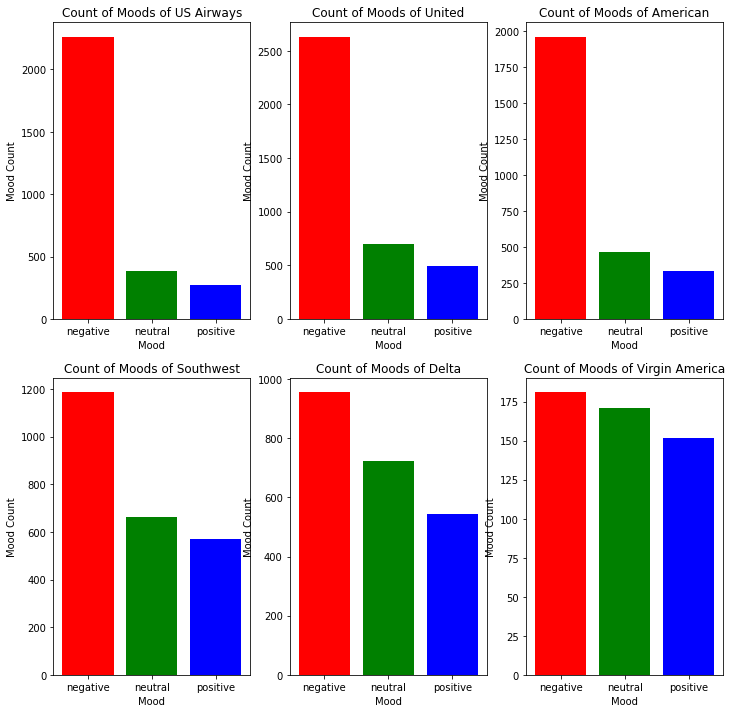

In [364]:
print("Total number of tweets for each airline \n ",data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=data[data['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

United, US Airways, American substantially get negative reactions.
Tweets for Virgin America are the most balanced.

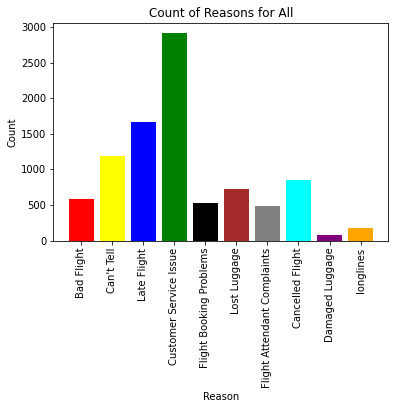

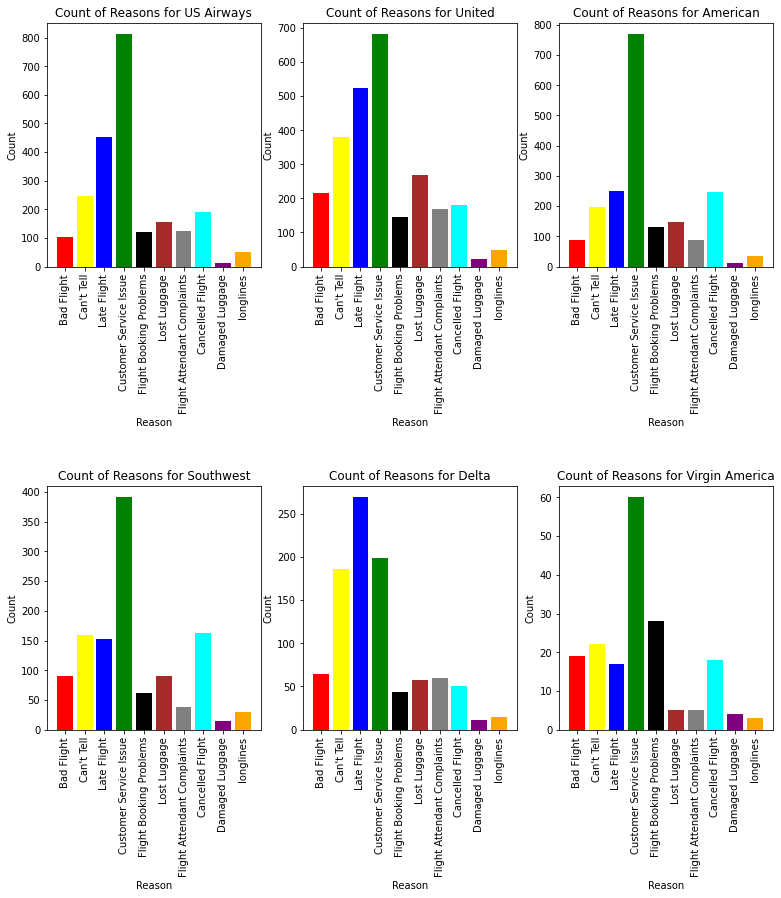

In [365]:
#get the number of negative reasons
data['negativereason'].nunique()

NR_Count=dict(data['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=data
    else:
        a=data[data['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(data['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

Customer Service Issue is the main neagtive reason for US Airways,United,American,Southwest,Virgin America

Late Flight is the main negative reason for Delta

Interestingly, Virgin America has the least count of negative reasons (all less than 60)

Contrastingly to Virgin America, airlines like US Airways,United,American have more than 500 negative reasons (Late flight, Customer Service Issue)

It will be interesting to see if the date has any effect on the sentiments of the tweets(especially negative !). We can draw various coclusions by visualizing this.

In [359]:
date = data.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

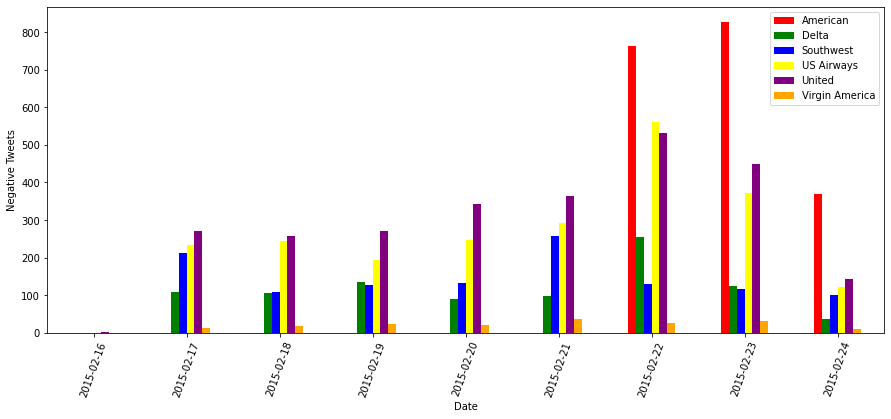

In [360]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

Interestingly, American has a sudden upsurge in negative sentimental tweets on 2015-02-23, which reduced to half the very next day 2015-02-24. (I hope American is doing better these days and resolved their Customer Service Issue as we saw before)
Virgin America has the least number of negative tweets throughout the weekly data that we have. It should be noted that the total number of tweets for Virgin America was also significantly less as compared to the rest airlines, and hence the least negative tweets.
The negative tweets for all the rest airlines is slightly skewed towards the end of the week !

In [366]:
# Only keeping airline sentiment, negative reason and text columns from the data, as these are useful for our analysis.

data = data.loc[:15000, ['airline_sentiment','negativereason', 'text']]

In [367]:
data['airline_sentiment'].value_counts()/len(data)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [368]:
data.isnull().sum(axis=0)                                # Check for NULL values.
# NULL values are present in negative reason which is expected for positive reason atleast 

airline_sentiment       0
negativereason       5462
text                    0
dtype: int64

In [369]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

data.head()                                 # Check first 5 rows of data

,airline_sentiment,negativereason,text
0,neutral,NaN,@VirginAmerica What @dhepburn said.
1,positive,NaN,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Bad Flight,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing about it


In [371]:
!pip install vaderSentiment

In [373]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [374]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
    

In [375]:
df1=data[:10]
df2=pd.DataFrame(list(map(sentiment_analyzer_scores,data['text'][:10])))

pd.concat([df1,df2],axis=1)

,airline_sentiment,negativereason,text,neg,neu,pos,compound
0,neutral,NaN,@VirginAmerica What @dhepburn said.,0.000,1.000,0.000,0.0000
1,positive,NaN,@VirginAmerica plus you've added commercials to the experience... tacky.,0.000,1.000,0.000,0.0000
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I need to take another trip!,0.000,1.000,0.000,0.0000
3,negative,Bad Flight,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0.226,0.645,0.129,-0.2716
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing about it,0.296,0.704,0.000,-0.5829
5,negative,Can't Tell,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,0.246,0.682,0.072,-0.5945
6,positive,NaN,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",0.000,0.695,0.305,0.6908
7,neutral,NaN,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",0.153,0.675,0.172,0.0790
8,positive,NaN,"@virginamerica Well, I didn't…but NOW I DO! :-D",0.000,0.483,0.517,0.7525
9,positive,NaN,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",0.000,0.642,0.358,0.7717


In [376]:
data.shape                                # Shape of data

(14640, 3)

### Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data

We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [378]:
#Html tag removal.
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,airline_sentiment,negativereason,text
0,neutral,NaN,@VirginAmerica What @dhepburn said.
1,positive,NaN,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Bad Flight,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing about it


In [379]:
# Replace contraction
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,airline_sentiment,negativereason,text
0,neutral,NaN,@VirginAmerica What @dhepburn said.
1,positive,NaN,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,NaN,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,Bad Flight,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,Can't Tell,@VirginAmerica and it is a really big bad thing about it


In [380]:
# Remove numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,negativereason,text
0,neutral,NaN,@VirginAmerica What @dhepburn said.
1,positive,NaN,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,NaN,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,Bad Flight,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,Can't Tell,@VirginAmerica and it is a really big bad thing about it


In [381]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [283]:
data.head()                                                                    # Look at how tokenized data looks.

,airline_sentiment,negativereason,text
0,neutral,NaN,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,NaN,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,NaN,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,Bad Flight,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,Can't Tell,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [382]:
# Remove stop word
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))                              

In [384]:
#Lemmatize or stemming

lemmatizer = WordNetLemmatizer()
#Remove non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
# Convert into lower case
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
# Remove punctuation
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
# Remove Stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words
# Lemmatize or stemming
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# Apply all above funtion and join the words in the list to convert back to text string in the dataframe
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,airline_sentiment,negativereason,text
0,neutral,NaN,virginamerica dhepburn say
1,positive,NaN,virginamerica plus add commercials experience tacky
2,neutral,NaN,virginamerica not today must mean need take another trip
3,negative,Bad Flight,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,Can't Tell,virginamerica really big bad thing


In [385]:
# Filter negative sentiment record negative reasons in separate dataframe
neg_df=data[data['airline_sentiment']=='negative']
neg_df = neg_df.drop('airline_sentiment', 1)
neg_df.head()

,negativereason,text
3,Bad Flight,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,Can't Tell,virginamerica really big bad thing
5,Can't Tell,virginamerica seriously would pay flight seat not play really bad thing fly va
15,Late Flight,virginamerica sfopdx schedule still mia
17,Bad Flight,virginamerica fly nyc sfo last week could not fully sit seat due two large gentleman either side help


In [386]:
# Data seems skewed
neg_df['negativereason'].value_counts()/len(neg_df)

Customer Service Issue         0.317063
Late Flight                    0.181412
Can't Tell                     0.129658
Cancelled Flight               0.092286
Lost Luggage                   0.078884
Bad Flight                     0.063195
Flight Booking Problems        0.057638
Flight Attendant Complaints    0.052408
longlines                      0.019394
Damaged Luggage                0.008063
Name: negativereason, dtype: float64

In [387]:
# Prepare dictionary for encoding negative reason categories
negativereason_nums = {"negativereason":     {"Customer Service Issue":0,
"Late Flight":1,
"Can't Tell":2,
"Cancelled Flight":3,
"Lost Luggage":4,
"Bad Flight":5,
"Flight Booking Problems":6,
"Flight Attendant Complaints":7,
"longlines":8,
"Damaged Luggage":9}}
# Replace negative reason categories with numbers
neg_df = neg_df.replace(negativereason_nums)
neg_df.head()

,negativereason,text
3,5,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,2,virginamerica really big bad thing
5,2,virginamerica seriously would pay flight seat not play really bad thing fly va
15,1,virginamerica sfopdx schedule still mia
17,5,virginamerica fly nyc sfo last week could not fully sit seat due two large gentleman either side help


In [388]:
# Prepare dictionary for encoding sentiment categories
airline_sentiment_nums = {"airline_sentiment":     {"negative": 1, "neutral": 0, "positive": 2}}
# Replace sentment categories with numbers
data = data.replace(airline_sentiment_nums)
data = data.drop('negativereason', 1)
data.head()

,airline_sentiment,text
0,0,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,0,virginamerica not today must mean need take another trip
3,1,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,1,virginamerica really big bad thing


In [390]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['text'])
neg_data_features = vectorizer.fit_transform(neg_df['text'])



In [391]:
data_features = data_features.toarray()                        # Convert the data features to array.
neg_data_features = neg_data_features.toarray()

In [392]:
type(data_features)

numpy.ndarray

In [393]:
neg_data_features.shape

(9178, 1000)

In [394]:
data_features.shape

(14640, 1000)

In [395]:
# Prepare labels for Negative reason & negative sentiment  
labels = data['airline_sentiment']
labels = labels.astype('int')
neg_labels = neg_df['negativereason']
neg_labels = neg_labels.astype('int')


In [396]:
neg_df.head(3)

,negativereason,text
3,5,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,2,virginamerica really big bad thing
5,2,virginamerica seriously would pay flight seat not play really bad thing fly va


In [397]:
data.head(3)

,airline_sentiment,text
0,0,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,0,virginamerica not today must mean need take another trip


In [398]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)
neg_X_train, neg_X_test, neg_y_train, neg_y_test = train_test_split(neg_data_features, neg_labels, test_size=0.3, random_state=42)


In [402]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
neg_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
neg_forest = neg_forest.fit(neg_X_train, neg_y_train)
print(forest)
print(neg_forest)
print("\n cross_val_score for sentiments")
print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))
print("\n cross_val_score for negative reason")
print(np.mean(cross_val_score(neg_forest, neg_data_features, neg_labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oo

In [403]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)
neg_result = neg_forest.predict(neg_X_test)

[[ 458  341   85]
 [ 284 2452   78]
 [ 131  188  375]]


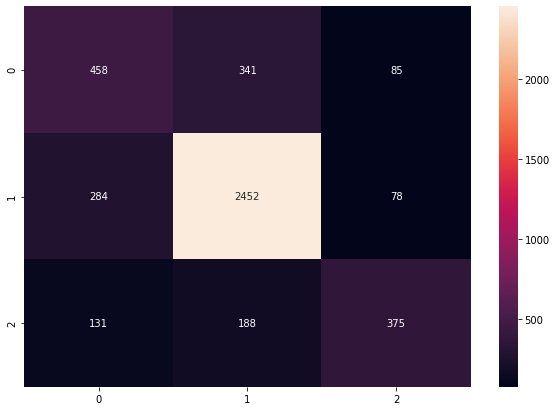

In [404]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

[[653  57  59  31  17  21  26   9   2   0]
 [ 53 371  38  12  14  17   4   5   3   0]
 [114  48 152   5  10  20   4   3   3   0]
 [ 31  23  19 177   3   3   4   1   0   0]
 [ 26  22  16   2 151   6   1   1   1   0]
 [ 43  35  22   3   5  43   5   3   0   0]
 [ 58  17  18   7   3   9  32   1   0   0]
 [ 41  27  17   2  11   5   0  33   0   1]
 [ 16  17   4   1   8   1   1   2   5   0]
 [  4   0   2   0  13   1   0   0   0   0]]


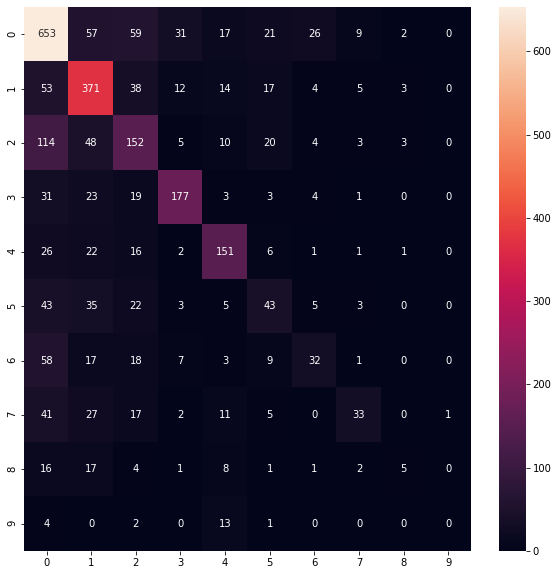

In [405]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(neg_y_test, neg_result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt='g')

In [409]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(data['text'])
neg_data_features = vectorizer.fit_transform(neg_df['text'])
data_features = data_features.toarray()
neg_data_features = neg_data_features.toarray()
print(neg_data_features.shape)
print(data_features.shape)

(9178, 1000)
(14640, 1000)


In [410]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
neg_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest = forest.fit(X_train, y_train)
neg_forest = neg_forest.fit(neg_X_train, neg_y_train)
print(forest)
print(neg_forest)
print("\n cross_val_score for sentiments")
print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))
print("\n cross_val_score for negative reason")
print(np.mean(cross_val_score(neg_forest, neg_data_features, neg_labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oo

In [411]:
result = forest.predict(X_test)
neg_result = neg_forest.predict(neg_X_test)

In [412]:
from sklearn.metrics import classification_report

print (classification_report(y_test, result))

print (classification_report(neg_y_test, neg_result))

              precision    recall  f1-score   support

           0       0.53      0.54      0.53       884
           1       0.83      0.86      0.85      2814
           2       0.72      0.60      0.65       694

    accuracy                           0.76      4392
   macro avg       0.69      0.66      0.68      4392
weighted avg       0.75      0.76      0.75      4392

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       875
           1       0.60      0.72      0.65       517
           2       0.40      0.43      0.42       359
           3       0.75      0.70      0.73       261
           4       0.64      0.62      0.63       226
           5       0.35      0.23      0.27       159
           6       0.39      0.20      0.26       145
           7       0.48      0.24      0.32       137
           8       0.31      0.07      0.12        55
           9       0.00      0.00      0.00        20

    accuracy           

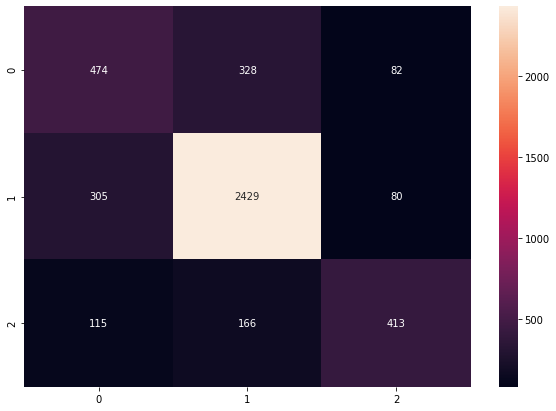

In [414]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

[[629  55  85  33  16  15  24  15   3   0]
 [ 63 371  41  13   8  11   3   4   3   0]
 [115  41 154   4  11  22   6   5   1   0]
 [ 26  23  14 184   4   4   4   2   0   0]
 [ 28  28  17   0 139   5   3   3   2   1]
 [ 35  40  34   1   7  36   3   3   0   0]
 [ 69  15  18   8   2   3  29   1   0   0]
 [ 49  24  14   1  11   5   0  33   0   0]
 [ 13  20   4   1   5   3   2   3   4   0]
 [  3   1   1   0  15   0   0   0   0   0]]


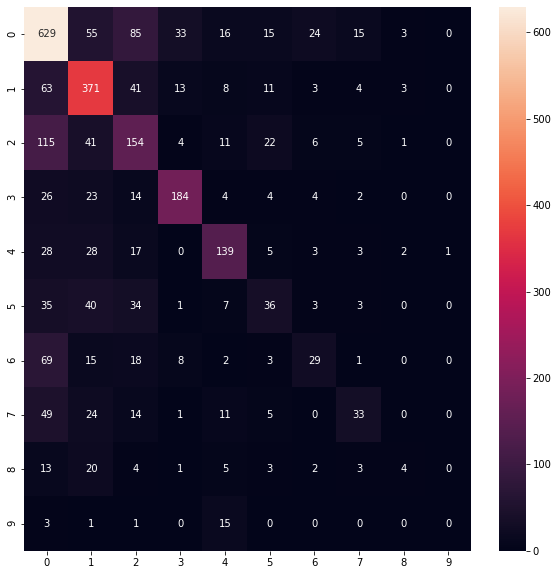

In [415]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(neg_y_test, neg_result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt='g')

Summary:

- We used dataset which has reviews in text format and their sentiment score on the scale of 0 - neutral, 1 - negative &  2 - positive.
- Also same dataset has negative reason for negative sentiment :
"Customer Service Issue":0,
"Late Flight":1,
"Can't Tell":2,
"Cancelled Flight":3,
"Lost Luggage":4,
"Bad Flight":5,
"Flight Booking Problems":6,
"Flight Attendant Complaints":7,
"longlines":8,
"Damaged Luggage":9
 
- The goal was to build a model for text-classification positive, negative, and neutral tweets.
- Also extended goal was to categorizing negative reasons for negative sentiment.
- As we you can see above we have plotted the confusion matrix for predicted sentiments and actual sentiments (negative,neutral and positive)
- As we you can see above we have plotted the confusion matrix for predicted negative reason category and actual negative reason category
- Both CountVectorizer & TfidfVectorizer are giving same performance
- Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report for sentiment. 